In [2]:
from nltk.util import ngrams
import pandas as pd
import sys
from nltk.util import ngrams
import csv
import gensim
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer
import numpy as np
import operator
import matplotlib.pyplot as plt
from pprint import pprint
import pyLDAvis.gensim

p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')
en_stop.append("ms")
en_stop.append("disorder")
en_stop.append("symptoms")
en_stop.append("mr")
en_stop.append("s")
en_stop.append("5")
en_stop.append("diagnosis")
en_stop.append("dsm")

In [21]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, iterations=50, id2word=dictionary)
        lm_list.append(lm)
        cm = gensim.models.coherencemodel.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence_per_topic())
        
    # Show graph
    x = range(1, limit)
    plt.boxplot(c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    fig = plt.figure(1, figsize=(9, 6))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(c_v)
    fig.savefig('fig1.png', bbox_inches='tight')

    return lm_list, c_v

In [4]:
all_text = []
diagnoses = []
with open('dsm_case_studies.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    next(reader, None)
    for row in reader:
        diagnoses.append(row[3])
        all_text.append(row[2]+row[4])
f.close()

In [48]:
# Without stemming
all_texts=[]
for i in all_text:
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    stopped_tokens = [i for i in tokens if not i in en_stop]
#     stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    all_texts.append(stopped_tokens)

['ashley', 'age', '17', 'referred', 'diagnostic', 'reevaluation', 'carried', 'diagnoses', 'autism', 'mental', 'retardation', 'almost', 'life', 'recently', 'found', 'kleefstra', 'syndrome', 'family', 'like', 'reconfirm', 'earlier', 'diagnoses', 'assess', 'genetic', 'risk', 'future', 'children', 'older', 'sisters', 'time', 'reevaluation', 'ashley', 'attending', 'special', 'school', 'focus', 'functional', 'skills', 'able', 'dress', 'able', 'shower', 'independently', 'left', 'alone', 'house', 'able', 'decode', 'e', 'g', 'read', 'words', 'spell', 'second', 'grade', 'level', 'understood', 'little', 'read', 'changes', 'schedule', 'heightened', 'functional', 'expectations', 'tended', 'make', 'irritable', 'upset', 'ashley', 'often', 'hurt', 'e', 'g', 'biting', 'wrist', 'others', 'e', 'g', 'pinching', 'hair', 'pulling', 'formal', 'testing', 'done', 'time', 'reevaluation', 'ashley', 'nonverbal', 'iq', '39', 'verbal', 'iq', '23', 'full', 'scale', 'iq', '31', 'adaptive', 'scores', 'somewhat', 'high

In [55]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = gensim.models.phrases.Phrases(all_texts, min_count=1)
for idx in range(len(all_texts)):
    for token in bigram[all_texts[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            all_texts[idx].append(token)
            

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:317: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if all(parameter in getargspec(scoring)[0] for parameter in scoring_parameters):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/phrases.py:

In [61]:
dictionary = gensim.corpora.Dictionary(all_texts)
# Filter out words that occur in less than 5 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=1, no_above=0.3)
corpus = [dictionary.doc2bow(doc) for doc in all_texts]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 11071
Number of documents: 87


In [62]:
num_topics = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, iterations=50, id2word = dictionary)

In [64]:
top_topics = ldamodel.top_topics(corpus, topn=10)
pprint(top_topics)

[([(0.0035124568, 'major_depression'),
   (0.0022498437, 'sexual'),
   (0.0016350582, 'wife'),
   (0.0016154988, 'bipolar'),
   (0.0015070396, 'substance_abuse'),
   (0.0014167969, 'pain'),
   (0.0014160454, 'husband'),
   (0.0012996789, 'primary_care'),
   (0.001285819, 'parents'),
   (0.0012583833, 'depressed_mood')],
  -1.6325940853597476),
 ([(0.0025222269, 'sexual'),
   (0.0016656492, 'major_depression'),
   (0.0014491649, 'bipolar'),
   (0.0013959423, 'major_depressive'),
   (0.001343763, 'care'),
   (0.0013325399, 'parents'),
   (0.0012593998, 'panic_attacks'),
   (0.0011658105, 'condition'),
   (0.0011348103, 'pain'),
   (0.001126553, 'sex')],
  -2.1416461248170298),
 ([(0.0019937849, 'major_depression'),
   (0.0018070235, 'schizophrenia'),
   (0.0016323517, 'wife'),
   (0.0015900608, 'bipolar'),
   (0.0015414738, 'alcohol_use'),
   (0.0015120285, 'major_depressive'),
   (0.0014714489, 'sexual'),
   (0.0012774242, 'parents'),
   (0.0012749737, 'withdrawal'),
   (0.0012703011, '

In [ ]:
from operator import itemgetter
import random
random.seed(123)

num_topics = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, iterations=50, id2word = dictionary)

top_topics = ldamodel.top_topics(corpus, topn=5, coherence = "c_v", texts = all_texts)

classes = {}
for i in range(len(corpus)):    
    classes.update({diagnoses[i][0:50]: max(ldamodel.get_document_topics(corpus[i]), key=itemgetter(1))[0]})

classes = sorted(classes.items(), key = itemgetter(1))

for i in range(len(top_topics)):
    print("Topic", i, "Coherence:", top_topics[i][1])

In [46]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
11     10.875441        1       1  0.036144 -0.017179
8      10.757405        1       2 -0.018019 -0.024338
6      10.548194        1       3 -0.006108  0.022231
2       9.658644        1       4 -0.028800  0.007434
1       9.465052        1       5  0.006571 -0.004722
0       9.366775        1       6 -0.003003 -0.011336
3       7.776200        1       7 -0.028084 -0.013522
9       7.120591        1       8  0.015462 -0.002915
4       6.900148        1       9  0.011147  0.028325
5       6.723952        1      10  0.021515 -0.003966
7       5.685366        1      11 -0.007742  0.006260
10      5.122232        1      12  0.000918  0.013726, topic_info=      Category         Freq  \
term                          
30938  Default   135.000000   
4176   Default   708.000000   
1824   Default  1120.000000   
22115  Default    89.000000   
3414   Default   237.000000   
22135  Default    79.000000   
22071  Default    77.000000   
27120  Default    96.000000   
26993  Default    85.000000   
22172  Default    78.000000   
22129  Default    78.000000   
27084  Default    84.000000   
22101  Default    79.000000   
33243  Default    73.000000   
33377  Default    62.000000   
27037  Default    96.000000   
27227  Default    83.000000   
21990  Default    77.000000   
27206  Default    84.000000   
18585  Default    57.000000   
36009  Default    96.000000   
22035  Default    79.000000   
27129  Default    97.000000   
27119  Default    84.000000   
22203  Default    64.000000   
18671  Default    62.000000   
22202  Default    78.000000   
27190  Default    96.000000   
21976  Default    77.000000   
18699  Default    62.000000   
...        ...          ...   
18639  Topic12     6.268113   
1824   Topic12    60.044878   
3645   Topic12    16.626443   
4176   Topic12    39.791061   
1585   Topic12    37.970483   
18535  Topic12     7.398688   
18443  Topic12     7.792283   
203    Topic12    19.854724   
344    Topic12    13.911235   
1341   Topic12    18.118236   
507    Topic12    17.324797   
3827   Topic12    12.573989   
5050   Topic12    15.487192   
3742   Topic12    11.808555   
11323  Topic12    14.366919   
6509   Topic12    11.503594   
4312   Topic12    12.132400   
470    Topic12    11.980764   
1736   Topic12    11.910915   
3626   Topic12    12.704125   
257    Topic12    13.200998   
3059   Topic12     9.582329   
8989   Topic12     9.808733   
3435   Topic12     9.477349   
3531   Topic12    10.040067   
4978   Topic12     9.368261   
6539   Topic12     9.761972   
7328   Topic12     9.937613   
1205   Topic12     9.378065   
14033  Topic12     9.122342   

                                                    Term        Total  \
term                                                                    
30938                                          late_life   135.000000   
4176                                    major_depression   708.000000   
1824                                       substance_use  1120.000000   
22115  obsessive_compulsive_depressive_anxiety_parent...    89.000000   
3414                                             1_month   237.000000   
22135  parents_tried_parents_reported_spent_time_beca...    79.000000   
22071  food_intake_weight_loss_fear_weight_somatic_co...    77.000000   
27120  least_three_impairment_distress_better_explain...    96.000000   
26993  32_year_presented_psychiatrist_young_children_...    85.000000   
22172  specific_phobia_clinical_attention_also_consid...    78.000000   
22129  parents_divorced_years_earlier_lived_mother_me...    78.000000   
27084  family_members_emotionally_abusive_emotionally...    84.000000   
22101  low_weight_gain_weight_year_old_maintain_position    79.000000   
33243         developmental_history_schizoid_personality    73.000000   
33377                               schizoid_personality    62.000000   
27037 

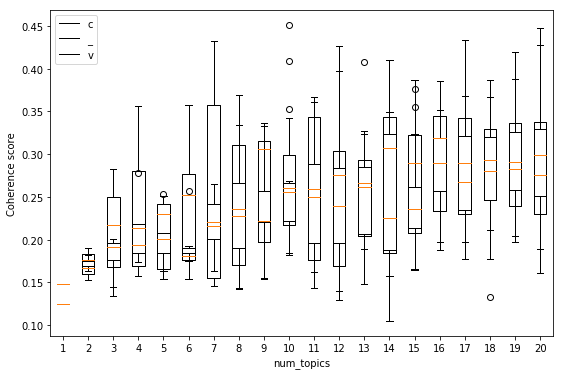

In [53]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=all_texts, limit=21)